## MSDS 7331 Data Mining: Project 2

***  

Team: Andrew Abbott, Vivek Bejugama, Patrick McDevitt, Preeti Swaminathan



***
	
We are using an online news popularity dataset from the UCI Machine Learning Repository. The dataset is a collection of 61 heterogeneous features for approximately 40,000 articles published by Mashable (www.mashable.com). The features are not the articles, but are extracted from the articles, such as word counts, title word counts, and keyword associations.  The data represents a two year period of published articles, ending in January 2015.  

We intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal is to predict the number of shares in social networks (popularity).  

The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.  

Measures for a successful outcome from a predictive model for this study will be based on overall accuracy metrics (e.g., confusion matrix), as well as AUC type metrics. A baseline (non-predictive, random) scoring will establish a baseline for these metrics, and then the predictive model can be assessed against a random model for measurement of improvement, i.e., value of the model.  

The data is located at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity  

***  
__Citation Request__ :  
***  
K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.  
***  


- The data set has features in these 6 broad categories :  
_(ref - see citation reference at beginning of this document)_  
    - Words  
        - Number of words of the title/content  
        - Average word length  
        - Rate of unique/non-stop words of contents
    - Links
        - Number of links  
        - Number of links to other articles in Mashable  
    - Digital Media  
        - Number of images/videos  
    - Time  
        - Day of the week/weekend  
    - Keywords  
        - Number of keywords  
        - Worst/best/average keywords (#shares)  
        - Article category  
    - NLP  
        - Closeness to five LDA topics  
        - Title/Text polarity/subjectivity  
        - Rate and polarity of positive/negative words  
        - Absolute subjectivity/polarity level  
     




## Classification Model Development - Overview  

#### The request for this project includes 2 different classification tasks and (at least) the development and interpretation of 3 different classification models. This section is provided as an overview of the structure of the model development that was employed for both tasks, and for each classifier evaluation. Due to the length of this report, this section is provided as an aid to follow the logic employed throughout this report.

#### The report includes 2 classification tasks :  

 1.0 - Prediction of article popularity for articles proposed for publication on _mashable.com_  web-site. This is binary prediction model (popular / not-popular). This was the original intention of the development of this dataset.  
 2.0 - Assignment of article to appropriate __data_channel__. This is additional task developed by this team, in fulfillment of additional use of data set to provide an appropriate business use. In this case, the problem is a multi-classifier problem, to identify to which of 7 data channels (e.g., World, Entertainment, Business, Technology, ...) an article is most appropriate.  
 
#### This report includes 4 classifier models for each of the above 2 classification tasks :  

 1. - Logistic Regression  
 2. - Decision Tree  
 3. - Random Forest  
 4. - Naïve Bayes  
 
#### The model development approach in all cases is as described here below :

1.	**Holdout** 20% of data set for final sacred test set

2.	Split remaining 80% into train / test for grid search  

3.	Run **Grid Search with CV 3** on each classification type  
    a.	Search on range of model parameters with cross-validation iteration of 3  

4.	Identify best accuracy / best parameters from **Grid Search**
    a.	Run each classifier model with best parameters for later **10-fold CV** verification  
    b.	Verify results are consistent with grid search model results

5.	Run full **10-fold CV** with the best parameters for each classifier
    a.	Verify results are consistent with prior grid search results  
    b.	Evaluate the 10-fold CV on model metrics (in our case Accuracy)

6.	Identify best overall model from the 4 classifiers after 10-fold CV  

7.	 Run best overall model on **Holdout** 20% sacred data set  
    a.	Report results from this test set run as expected model capability  

8.	Identify **feature importance** from each of the 4 classifier models (best model each)    
    a.	Consider if feature scaling is beneficial for interpretation  

9.	Identify strengths / weakness of model prediction capability (e.g., some classes well predicted or not)

 <img src = '../proj_02/model_development_method.png'>

#### Import required packages  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time

from pylab import rcParams
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read in dataset from .csv file  

In [4]:
data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)  

In [5]:
df.columns = df.columns.str.strip()
col_names = df.columns.values.tolist()


# Data Preparation Part 1	
10	
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Task 1 data set definition  

 - For Task 1 we intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal is to predict the number of shares in social networks (popularity). 
 - The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.   
 - In order to support this classification task, we create a new dependent variable column __popular__  which is true if the value of __shares__ is greater than 1400.

In [6]:
popular_binary = np.where(df['shares'] > 1400, True, False)

df.insert(loc = 0, column = 'popular', value = popular_binary)

del df['shares'] 

In [7]:
df.popular.value_counts()

False    20082
True     19562
Name: popular, dtype: int64

In [8]:
del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']
del df['url']

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534
num_keywords,39644.0,7.223767,1.909130,1.00000,6.000000,7.000000,9.000000,10.000000
data_channel_is_lifestyle,39644.0,0.052946,0.223929,0.00000,0.000000,0.000000,0.000000,1.000000


#### Assign certain variables to type integer, as appropriate

In [10]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend']
    

df[to_int] = df[to_int ].astype(np.int64)

In [11]:
df[df.duplicated()]

,popular,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity


#### Impute kw_avg_max for 0-values and re-scale to standard normal scale

 - A small number of rows have 0 value for __kw_avg_max__, which is completely out of range for the remaining rows of this variable.    
 - We will impute these rows to median value of the column  
 
 - The magnitude of this column of data is markedly different than the range of values in the remaining columns in the data set. To bring this back in line, we will re-scale the values in this column to standard normal range

In [12]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  impute to median value for a few rows of kw_avg_max
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.kw_avg_max.median()

condition = df['kw_avg_max'] == 0
df.loc[condition, 'kw_avg_max'] = df.kw_avg_max.median()

df.kw_avg_max.median()


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  scale to standard normal scale
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()

df.kw_avg_max = (df.kw_avg_max - df.kw_avg_max.mean()) / df.kw_avg_max.std()

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()


244572.22222250002

244575.00000025

#### Constant offset for variables with min value < 0  

 - This allows to consider these variables for ln() transform if highly right-skewed and also supports some classification models that only accept independent variables that are > 0  
 - Method here is to just add -1 * min_value of any column for which min_value < 0

In [14]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  for all columns with negative values, add +1 to all values in the column
# ...  - the only columns with negative values are polarity / sentiment measures
# ...  - adding a constant to all values does not modify distributions
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])
numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for min < 0, add constant as applicable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names :
    if df_mins[column] < 0 :
        df[column] = df[column] - df_mins[column]
        
#        print('--> min_value < 0 adjusted : ', column, df_mins[column])

#### Ln() transform for variables that are right skewed (skewness > 1)  

 - This facilitiates maintaining more normally distributed residuals for regression models  
 - Likely, this will not be needed for the classification task, at present, but also does not have negative effects for this current activity


In [15]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')

# ...  these are binary indicators ... so no need to ln-transform

del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']
del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')

#columns_to_drop.remove('data_channel')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))

df.drop(columns_to_drop, axis = 1, inplace = True)

#df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
data_channel_is_lifestyle 3.99301914336 ln_data_channel_is_lifestyle
data_channel_is_entertainment 1.6835848094 ln_data_channel_is_entertainment
data_channel_is_bus 1.87687018599 ln_data_channel_is_bus
data_channel_is_socmed 3.75887963097 ln_data_channel_is_socmed
data_channel_is_tech 1.61997576469 ln_data_channel_is_tech
data_channel_is_world 1.40516938412 ln_data_channel_is_world
kw_min_min 2.37494728018 ln_kw_min_min
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.914093

# Data Preparation Part 2

#### Data Selection - Task 1 - Popularity classification

- There are 60 columns in the original data set; we added an additonal column based on the value of shares as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [16]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)


icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares  ln_self_reference_avg_sharess       0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess       0.971014
ln_kw_max_min                 ln_kw_avg_min                       0.946087
ln_self_reference_min_shares  ln_self_reference_max_shares        0.945943
kw_min_avg                    ln_kw_min_max                       0.926784
ln_kw_max_avg                 ln_kw_avg_avg                       0.899409
LDA_02                        ln_data_channel_is_world            0.836618
timedelta                     ln_kw_min_min                       0.822783
kw_max_max                    ln_kw_min_min                       0.820625
rate_negative_words           ln_global_rate_negative_words       0.782517
LDA_00                        ln_data_channel_is_bus              0.774651
average_token_length          ln_n_tokens_content                 0.768795
LDA_04       

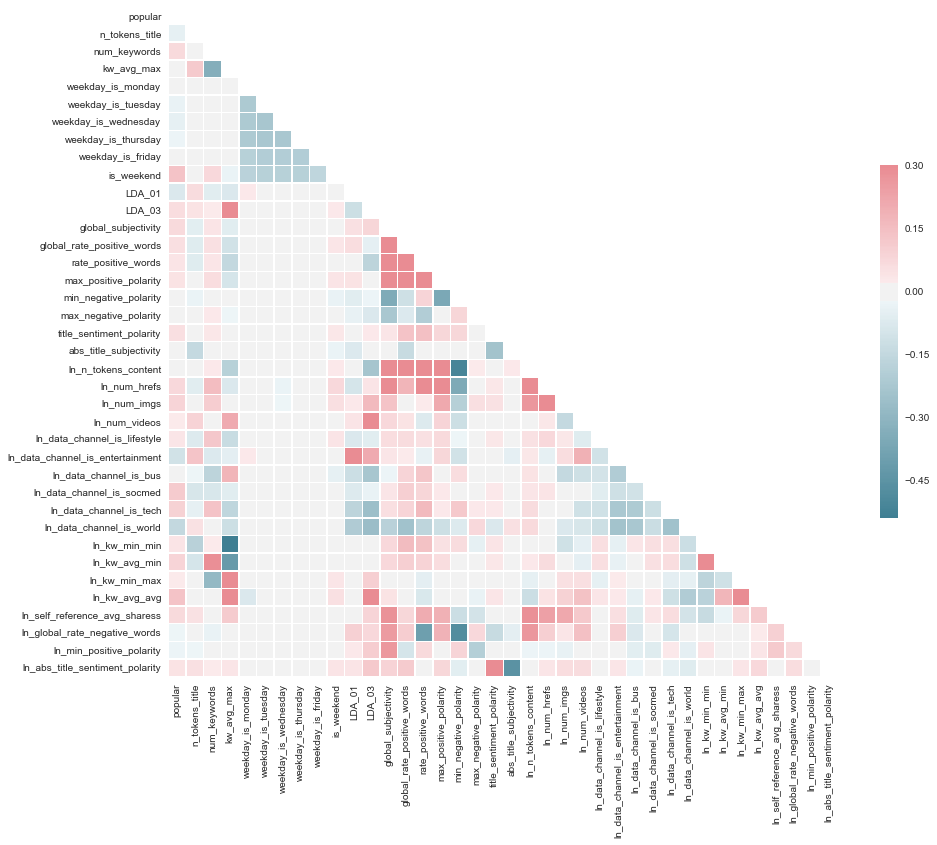

In [17]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

#### Save cleaned / reduced data set to external .csv file  

 - This provides opportunity to just read in this .csv file and no need to repeat data cleaning / reduction process for each execution  
 

In [18]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = 'data/'
data_file = 'mashable_clean_dataset_for_lab_02_task_01.csv'

file_2_write = data_dir + data_file

df.to_csv(file_2_write, index = False)


# 	Modeling and Evaluation 2

### Training and test split

In [23]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  copy data frame to classification working data frame
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... data set with text categorical target values 

df_pop = df.copy()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_pop:
    y = df_pop['popular'].values         # set 'popular as dependent
    del df_pop['popular']                 # remove from dataset
    X = df_pop.values                        # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup master train and test , golden traina and test
# ...  master sets - first 80% of original data set which will be base training for model building
# ...  Golden sets - 20% of original will be used in the final best model for prediction
# ...  split into training and test sets
# ....  --> 10 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=




In [25]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up golden test data set
# ... This data-set will be used to evaluate the predictive capability of the final
# ... model on a data set that was not included in any of the prior train/test sets
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(X, y):
    master_X_train = X[train_indices]
    master_y_train = y[train_indices]    
    golden_X_test  = X[test_indices]
    golden_y_test  = y[test_indices]
    print(master_X_train.shape)


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(31715, 37)


In [26]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up training set to be used on 'best' model from grid search results
# ... This data-set will be used to verify 10-fold-CV-model has results consistent
# ... with the model produced from grid search
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(master_X_train, master_y_train):
    X_train = master_X_train[train_indices]
    y_train = master_y_train[train_indices]    
    X_test  = master_X_train[test_indices]
    y_test  = master_y_train[test_indices]
    print(X_train.shape)


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(25372, 37)


In [27]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = [
    'Model Name',
    'Accuracy',
    'Precision',
    'Recall',
    'FScore',
    'Processing Time'])

i_index=[]
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

# 	Modeling and Evaluation 3	

For task 1 we have chosen the following 4 models:<br>
a. Multinomial logistic regression with parament selection using Grid Search<br>
b. Decision Tree with parament selection using Grid Search<br>
c. Random Forest with parament selection using Grid Search<br>
d. Naive Bayes<br>

Each of these models will be evaluated on Accuracy, Precision, Recall, FScore and Execution time

### a. Multinomial logistic regression
For multinomial LR we have set standard attributes with:
    class_weight = balanced<br>
    multi_class = multinomial<br>
<b>search params:</b><br>
    tolerance parament tol<br>
    Regularization parament C<br>
    
    
#### _Grid selection for logistic regression_

In [28]:
from sklearn.grid_search import GridSearchCV

lr_model = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 10,
    tol = 0.1)

params = {
    'C':[100, 1000], 
    'tol': [0.001, 0.0001]
}

# ... --> changed the scoring on Sat 28-Oct
# ...     - from : log_loss
# ...     - to : neg_log_loss
# ...  (this avoids the deprecation warning)

clf = GridSearchCV(
    lr_model,
    params,
    scoring = 'neg_log_loss',
    refit = 'True',
    n_jobs = -1,
    cv = 5)

grid_search = clf.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/Users/andrewabbott/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/andrewabbott/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### _Best parameter values for logistic regression_:

In [29]:
best_accuracy
best_parameters

-0.6543171581135381

{'C': 1000, 'tol': 0.001}

#### Create main logistic model using best paraments for further analysis and model comparisons

In [30]:
tic = time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... basic multiclass Logistic Regression
# ... - normalize features based on mean & stdev of each column
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

lr_model1 = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 100,
    tol = 0.001)

lr_model1.fit(X_train, y_train)  # train object

y_hat = lr_model1.predict(X_test) # get test set precitions

toc =  time.clock()

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_hat,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_hat,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_hat,average='weighted'))

exetime = '{0:.4f}'.format(toc-tic)

# print statistics

print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", conf(y_test, y_hat))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name' : 'Logistic Regression',
    'Accuracy' : accuracy,
    'Precision' : precision,
    'Recall' : recall,
    'FScore' : f1_score,
    'Processing Time' : exetime
}

df_tbl = pd.DataFrame(raw_data,
    columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'FScore', 'Processing Time'],
    index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Logistic Regression', lr_model1))


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.001, verbose=0,
          warm_start=False)

accuracy 0.6393
precision 0.6393
recall 0.6393
f1_score 0.6393
confusion matrix
 [[2059 1153]
 [1135 1996]]
process time 1.0215




### Interpreting Weights

In [47]:
# Interpreting weights
zip_vars = zip(sum(abs(lr_model1.coef_)).T,df_pop.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print('\t %50s - weight = %9.3f', name, coef) # now print them out

ln_kw_min_max has weight of 0.0032638888931
global_rate_positive_words has weight of 0.00796926404498
n_tokens_title has weight of 0.011473890282
ln_self_reference_avg_sharess has weight of 0.0134654010026
num_keywords has weight of 0.014882519123
rate_positive_words has weight of 0.0181278807964
ln_kw_min_min has weight of 0.0219297304698
max_positive_polarity has weight of 0.0273507386774
kw_avg_max has weight of 0.0281762867706
ln_kw_avg_min has weight of 0.029590277054
ln_data_channel_is_tech has weight of 0.0341748080512
ln_global_rate_negative_words has weight of 0.0455480694208
ln_num_videos has weight of 0.0549512914584
title_sentiment_polarity has weight of 0.0604263888966
ln_num_hrefs has weight of 0.0647917364695
ln_n_tokens_content has weight of 0.0704353785547
ln_num_imgs has weight of 0.0708348659893
min_negative_polarity has weight of 0.0811932350643
global_subjectivity has weight of 0.089141918333
abs_title_subjectivity has weight of 0.1054326921
ln_data_channel_is_life

To interpret the weights of each variable, I used the sums of the absolute values of the coefficients of each variable for each class. Because a particular variable might be highly positively predictive of one class and highly negatively predictive of another class, their sums would appear to have little value. I sum the absolute values to measure the total predictive value across all classes.  
It does not surprise me to see that Social Media data channel is the most predictive, since social media by nature involves sharing with connections, followed by World data channel and positive polarity. Overall, data channels social media and world, and positive polarity are more predictive of the popularity.

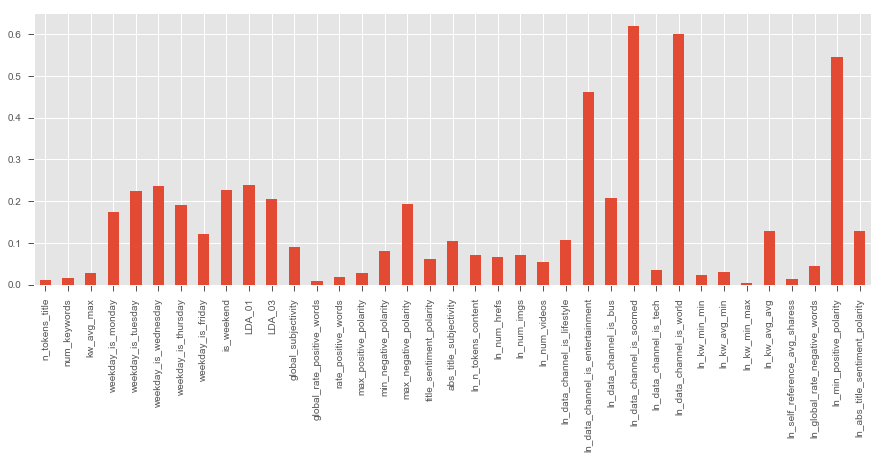

In [58]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')

weights = pd.Series(sum(abs(lr_model1.coef_)), index = df_pop.columns)
weights.plot(kind = 'bar')
plt.show()

Above is a visual representaion of the magnitudes of the coefficients.

### b. Decision Tree Classifier using Grid Search
#### _Grid search parameter set-up_

In [31]:
# Applying Grid Search to find the best model and the best parameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

parameters = [
      {
        'criterion': ['gini'], 
        'max_depth': [None], 
        'min_samples_split': [2, 100, 1000], 
        'min_samples_leaf': [1, 10, 100],
        'max_features': [None], 'max_leaf_nodes': [None]
      },
      {
          'criterion': ['entropy'], 
          'max_depth': [None, 5, 10], 
          'min_samples_split': [2, 100, 1000],
          'min_samples_leaf': [1, 10, 100], 
          'max_leaf_nodes': [None]
      }
     ]

grid_search = GridSearchCV(estimator = DTclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search = grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_


#### _Best parameters for Decision Tree_

In [32]:
best_accuracy
best_parameters

0.63846760208103426

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': None,
 'min_samples_leaf': 100,
 'min_samples_split': 1000}

#### _use best parameters to create best Decision Tree model for further analysis and model comparison_

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report

tic = time.clock()

# train and fit

DTclassifier = DecisionTreeClassifier(
    criterion = 'gini',
    min_samples_leaf = 10,
    min_samples_split = 100)

DTclassifier.fit(X_train, y_train)
y_predDT = DTclassifier.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predDT))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predDT,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predDT,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predDT,average='weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predDT))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name':'Decision Tree Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Decision Tree Classifier', DTclassifier))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

accuracy 0.6204
precision 0.6207
recall 0.6204
f1_score 0.6197
confusion matrix
 [[2123 1089]
 [1319 1812]]
process time 0.4279




### Interpretation of importances.

In [55]:
# Interpreting weights
zip_varsDT = zip(DTclassifier.feature_importances_.T,df_pop.columns) # combine attributes
zip_varsDT = sorted(zip_varsDT)
for importance, name in zip_varsDT:
    print(name, 'has weight of', importance) # now print them out

weekday_is_wednesday has weight of 0.0
weekday_is_thursday has weight of 0.000578097783969
weekday_is_monday has weight of 0.000786768852518
weekday_is_friday has weight of 0.00176642137287
weekday_is_tuesday has weight of 0.00180125917947
ln_data_channel_is_bus has weight of 0.00202916488296
num_keywords has weight of 0.00345420525329
ln_data_channel_is_lifestyle has weight of 0.00440877271989
ln_num_videos has weight of 0.00654951816331
min_negative_polarity has weight of 0.00675700914442
abs_title_subjectivity has weight of 0.00908405585137
ln_kw_min_min has weight of 0.00911938023328
max_negative_polarity has weight of 0.00915260202382
n_tokens_title has weight of 0.00969173829221
title_sentiment_polarity has weight of 0.0114990457279
ln_abs_title_sentiment_polarity has weight of 0.0126717954334
max_positive_polarity has weight of 0.0128727705034
ln_data_channel_is_world has weight of 0.0151972150309
ln_num_imgs has weight of 0.0164721955082
rate_positive_words has weight of 0.0182

In the decision tree model, the importance of the variables are not the same as they were in the logistic regression model examined earlier. The amount of key words is most important, next are self reference average shares. This result is interesting and maybe not intuitive, but variables such as the weekend indicator and variables related to the actual sharing process such as keywords show up here.

### c. Random Forest Classifier

#### _Grid Search parameter set-up for Random Forest classifier_

In [34]:
RFclf = RandomForestClassifier(
    criterion = 'entropy',
    max_features= 'sqrt',
    max_depth = 5,
    n_estimators = 10,
    n_jobs = -1)

#RFclf.fit(master_X_train, master_y_train)

param_grid =[
    { 
    'criterion': ['gini'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
},
 { 
    'criterion': ['entropy'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
}
]

RF_grid_search = GridSearchCV(
    estimator = RFclf,
    param_grid = param_grid,
    cv = 2)

grid_search = RF_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_features = best_parameters['max_features']
best_n_estimators = best_parameters['n_estimators']


#### _best parameters for Random Forest Classifier_

In [35]:
best_accuracy
best_parameters

0.66268327289925899

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500}

#### _using best parameters for main model for further analysis and model comparison_

In [36]:
from sklearn.ensemble import RandomForestClassifier

tic = time.clock()

# train and test 

RFclf = RandomForestClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    max_features = best_max_features,
    n_estimators = best_n_estimators,
    n_jobs = -1)

RFclf.fit(X_train, y_train)
y_predRF = RFclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predRF))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predRF, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predRF, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predRF, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Random Forest Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Random Forest Classifier', RFclf))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

accuracy 0.6648
precision 0.6648
recall 0.6648
f1_score 0.6648
confusion matrix
 [[2175 1037]
 [1089 2042]]
process time 32.5097




### Interpreting weights

In [59]:
# Interpreting weights
zip_varsRF = zip(RFclf.feature_importances_.T,df_pop.columns) # combine attributes
zip_varsRF = sorted(zip_varsRF)
for importance, name in zip_varsDT:
    print(name, 'has weight of', importance) # now print them out

weekday_is_wednesday has weight of 0.0
weekday_is_thursday has weight of 0.000578097783969
weekday_is_monday has weight of 0.000786768852518
weekday_is_friday has weight of 0.00176642137287
weekday_is_tuesday has weight of 0.00180125917947
ln_data_channel_is_bus has weight of 0.00202916488296
num_keywords has weight of 0.00345420525329
ln_data_channel_is_lifestyle has weight of 0.00440877271989
ln_num_videos has weight of 0.00654951816331
min_negative_polarity has weight of 0.00675700914442
abs_title_subjectivity has weight of 0.00908405585137
ln_kw_min_min has weight of 0.00911938023328
max_negative_polarity has weight of 0.00915260202382
n_tokens_title has weight of 0.00969173829221
title_sentiment_polarity has weight of 0.0114990457279
ln_abs_title_sentiment_polarity has weight of 0.0126717954334
max_positive_polarity has weight of 0.0128727705034
ln_data_channel_is_world has weight of 0.0151972150309
ln_num_imgs has weight of 0.0164721955082
rate_positive_words has weight of 0.0182

In the random forest model, the importance of the variables are not the same as they were in the logistic regression model examined earlier ubt very similar to the decision tree model. The amount of key words is most important, next are self reference average shares. This result is interesting and maybe not intuitive, but variables such as the weekend indicator and variables related to the actual sharing process such as keywords show up here.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<Container object of 37 artists>

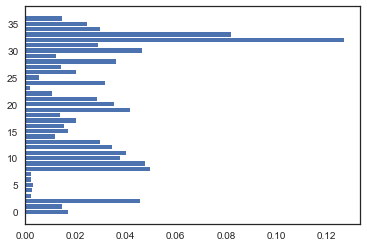

In [37]:
print (RFclf)
plt.barh(range(len(RFclf.feature_importances_)), RFclf.feature_importances_)
plt.show()

#  3: Naive Bayes ***


In [38]:
from sklearn.naive_bayes import MultinomialNB

MNBclf = MultinomialNB(
    alpha = 0.01,
    class_prior = None,
    fit_prior = True)

params = {
    'alpha':[0.1, 0.5, 1.0]
}

MNB_grid_search = GridSearchCV(
    MNBclf,
    params,
    cv = 5)

grid_search = MNB_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy
best_parameters

best_alpha = best_parameters['alpha']

0.62090493457354567

{'alpha': 0.1}

In [39]:
tic = time.clock()

# train and test 

MNBclf = MultinomialNB(
    alpha = best_alpha,
    class_prior = None,
    fit_prior = True)

MNBclf.fit(X_train, y_train)
y_predMNB = MNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predMNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predMNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predMNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predMNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predMNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Multinomial Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Multinomial Naïve Bayes', MNBclf))


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

accuracy 0.6237
precision 0.6239
recall 0.6237
f1_score 0.6232
confusion matrix
 [[2116 1096]
 [1291 1840]]
process time 0.0166




In [40]:
from sklearn.naive_bayes import GaussianNB

tic = time.clock()

# train and test 

GNBclf = GaussianNB()

GNBclf.fit(X_train, y_train)
y_predGNB = GNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predGNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predGNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predGNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predGNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predGNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Gaussian Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Gaussian Naïve Bayes', GNBclf))

GaussianNB(priors=None)

accuracy 0.6249
precision 0.6255
recall 0.6249
f1_score 0.6240
confusion matrix
 [[2165 1047]
 [1332 1799]]
process time 0.0499




#	Modeling and Evaluation 4

In [41]:
# converting acc, pre, recall, fscore and time to numeric values for plots

comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['Precision'] = pd.to_numeric(comparison_tbl['Precision'])
comparison_tbl['Accuracy'] = pd.to_numeric(comparison_tbl['Accuracy'])
comparison_tbl['FScore']= pd.to_numeric(comparison_tbl['FScore'])
comparison_tbl['Processing Time'] = pd.to_numeric(comparison_tbl['Processing Time'])
comparison_tbl['Recall'] = pd.to_numeric(comparison_tbl['Recall'])
comparison_tbl


,Model Name,Accuracy,Precision,Recall,FScore,Processing Time
0,Logistic Regression,0.6393,0.6393,0.6393,0.6393,1.0215
1,Decision Tree Classifier,0.6204,0.6207,0.6204,0.6197,0.4279
2,Random Forest Classifier,0.6648,0.6648,0.6648,0.6648,32.5097
3,Multinomial Naïve Bayes,0.6237,0.6239,0.6237,0.6232,0.0166
4,Gaussian Naïve Bayes,0.6249,0.6255,0.6249,0.6240,0.0499


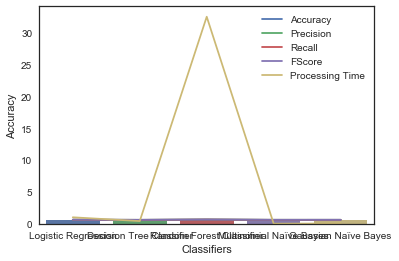

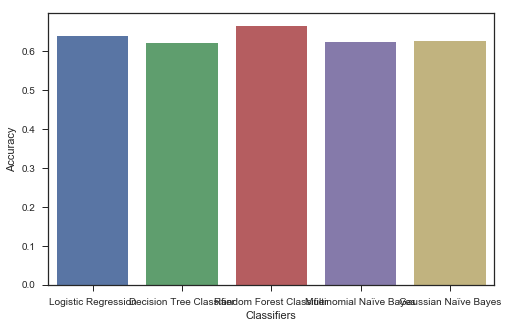

In [42]:
from pylab import rcParams
%matplotlib inline

comparison_tbl.plot()

rcParams['figure.figsize'] = 8, 5
sns.set(style="ticks")
sns.barplot(data=comparison_tbl,y='Accuracy',x='Model Name')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

sns.barplot(data=comparison_tbl,y='Precision',x='Model Name')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()



# 10-K Cross-Validation for each classifier
For each classifier we run 10 fold cross validation which will help us narrow down one final model

In [43]:
from sklearn import model_selection

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = model_selection.cross_val_score(
        model,
        master_X_train,
        master_y_train,
        cv = 10,
        scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "\n\t%50s: %.3f (%.4f)\n\n" % (name, cv_results.mean(), cv_results.std())
    print(cv_results)
    print(msg)

[ 0.6281122   0.63157895  0.63587642  0.62945443  0.65247556  0.63639231
  0.63859981  0.64364554  0.63355408  0.62283191]

	                               Logistic Regression: 0.635 (0.0080)


[ 0.61014812  0.60605106  0.61443884  0.62503942  0.60769473  0.62630085
  0.62535478  0.60580259  0.61400189  0.61147903]

	                          Decision Tree Classifier: 0.615 (0.0077)


[ 0.65994327  0.66939805  0.66393443  0.65941343  0.66918953  0.66572059
  0.67139704  0.66666667  0.65689057  0.64900662]

	                          Random Forest Classifier: 0.663 (0.0065)


[ 0.62243933  0.62243933  0.62200504  0.62157048  0.63260801  0.61368653
  0.62283191  0.62976979  0.61715547  0.61431725]

	                           Multinomial Naïve Bayes: 0.622 (0.0057)


[ 0.6265364   0.62275449  0.62042875  0.6244087   0.63008515  0.63008515
  0.62913907  0.62251656  0.62598549  0.61431725]

	                              Gaussian Naïve Bayes: 0.625 (0.0047)




{'boxes': [<matplotlib.lines.Line2D at 0x108d9aa90>,
 'caps': [<matplotlib.lines.Line2D at 0x108e27cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x108e2be80>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x108d9f518>,
 'whiskers': [<matplotlib.lines.Line2D at 0x108d9a320>,
  <matplotlib.lines.Line2D at 0x108e43cf8>]}

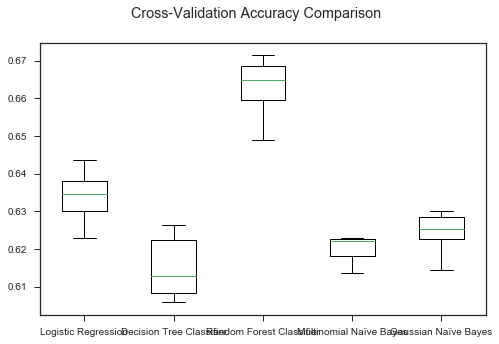

In [44]:
# boxplot accuracy comparison

fig = plt.figure()
fig.suptitle('Cross-Validation Accuracy Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names)
plt.show()


#### Golden test data set prediction with our final model

our final best model is Random Forest Classifier. We will run prediction on that fit with the test data set we set aside at the beggining of the project. We will calculate statistics for the prediction.

In [45]:
y_predFinal = RFclf.predict(golden_X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(golden_y_test, y_predFinal))
precision = '{0:.4f}'.format(metrics.precision_score(golden_y_test, y_predFinal, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(golden_y_test, y_predFinal, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(golden_y_test, y_predFinal, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy", accuracy )
print("precision", precision )
print("recall", recall )
print("f1_score", f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time', exetime)
print("\n")


accuracy 0.6590
precision 0.6589
recall 0.6590
f1_score 0.6589
confusion matrix
 [[2175 1037]
 [1089 2042]]
process time 385.6535




  
<hr size = "5">  

# Task 02 - Second Classifier  

<hr size = "5">  



## --- This needs more work  
### --> copy data prep 01 & 02 from mini-lab ... hopefully there is enough there  
### --> Model&Eval 01 just addresses Task 1 for now ... need to complete this and also add Task 2 business discussion  


### __Data Prep 01__  

Define and prepare your class variables.  

### __Data Prep 02__  

Describe the final dataset that is used for classification / regression.  

### __Modeling and Evaluation 01__   

Choose and explain the evaluation metrics that we will use. Why are the measures appropriate for analyzing the results of this model ? Give a detailed explanation backing up any assertions.

We intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal in _Task 1_ is to predict the number of shares in social networks (popularity).  

The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.  

Measures for a successful outcome from a predictive model for this study will be based on overall accuracy metrics (e.g., confusion matrix), as well as AUC type metrics. A baseline (non-predictive, random) scoring will establish a baseline for these metrics, and then the predictive model can be assessed against a random model for measurement of improvement, i.e., value of the model.  

For this business case, we consider 2 risks :  
 - 1 - there is an article that has high potential for high popularity and our model classifies this incorrectly as not popular  
 - 2 - there are articles that are not likely to be popular, and our model incorrectly classifies the article as high potential for high popularity  
  
  In the first case, our model is missing opportunity to identify a highly valuable asset, whereas in the second case our model highly values that which has no value. For our business case, the distinction between popular and not_popular was established at the median value for number of shares of each article. In this case, then, there are, by this measure, an equal number of popular and not_popular articles. 

***  

## Classification Model Development - Overview  

1.	**Holdout** 20% of data set for final sacred test set

2.	Split remaining 80% into train / test for grid search  

3.	Run **Grid Search with CV 3** on each classification type  
    a.	Search on range of model parameters with cross-validation iteration of 3  

4.	Identify best accuracy / best parameters from **Grid Search**
    a.	Run each classifier model with best parameters for later **10-fold CV** verification  
    b.	Verify results are consistent with grid search model results

5.	Run full **10-fold CV** with the best parameters for each classifier
    a.	Verify results are consistent with prior grid search results  
    b.	Evaluate the 10-fold CV on model metrics (in our case Accuracy)

6.	Identify best overall model from the 4 classifiers after 10-fold CV  

7.	 Run best overall model on **Holdout** 20% sacred data set  
    a.	Report results from this test set run as expected model capability  

8.	Identify **feature importance** from each of the 4 classifier models (best model each)    
    a.	Consider if feature scaling is beneficial for interpretation  

9.	Identify strengths / weakness of model prediction capability (e.g., some classes well predicted or not)

 <img src = '../proj_02/model_development_method.png'>

 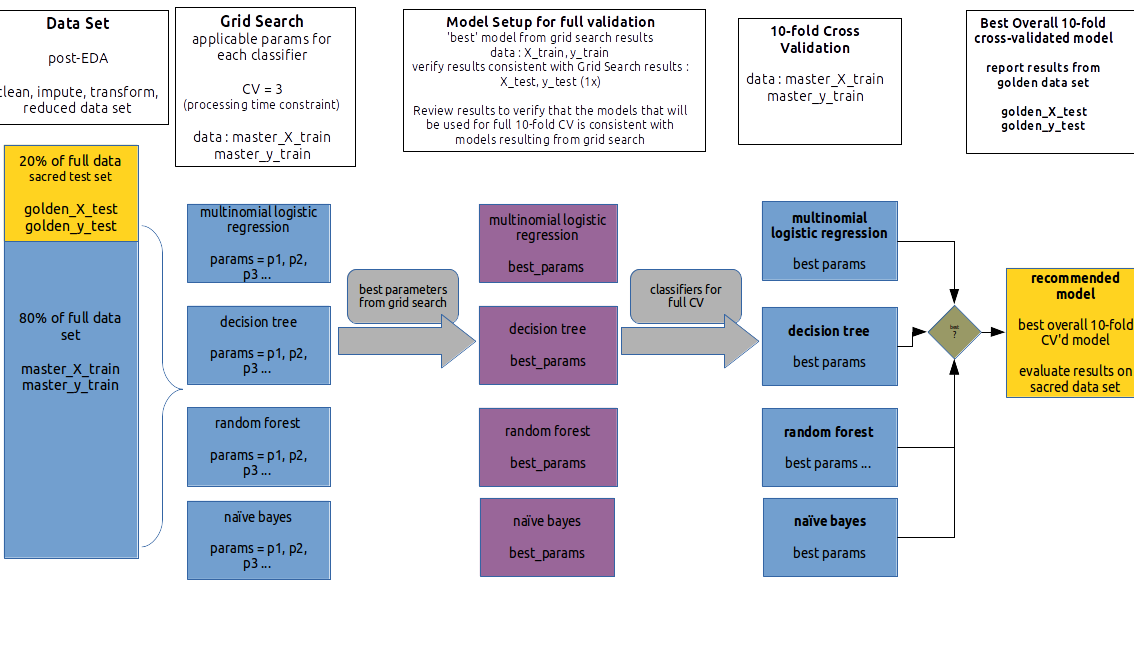

#### Import required packages  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read in dataset from .csv file  

In [35]:
data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)  

In [36]:
df.columns = df.columns.str.strip()
col_names = df.columns.values.tolist()

['url',
 'timedelta',
 'n_tokens_title',
 'n_tokens_content',
 'n_unique_tokens',
 'n_non_stop_words',
 'n_non_stop_unique_tokens',
 'num_hrefs',
 'num_self_hrefs',
 'num_imgs',
 'num_videos',
 'average_token_length',
 'num_keywords',
 'data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'kw_min_min',
 'kw_max_min',
 'kw_avg_min',
 'kw_min_max',
 'kw_max_max',
 'kw_avg_max',
 'kw_min_avg',
 'kw_max_avg',
 'kw_avg_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'self_reference_avg_sharess',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'LDA_03',
 'LDA_04',
 'global_subjectivity',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'rate_positive_words',
 

# Data Preparation Part 1	

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Task 2 data set definition  

 - For Task 2 classification we will classify the articles according to which data channel they are most likely to belong. The business case for this is to support directing the article to the data_channel most appropriate for the article content.  
 - In order to support this classification task, we create a new dependent variable column __data_channel__  which combines all of the individual binary boolean columns of __data_channel_is_xxx__ to __data_channel__ column with appropriate value  
 - We create 2 sets of this dependent variable, __data_channel__ and __data_channel_n__ . The only difference between these 2 columns is that __data_channel__ contains the text values for data channel category while the __data_channel_n__ contains an integer classifier (1 --> 7) which we associate to the text description in alphabetic order.  We create 2 versions of the column to be able to use the text version, when feasible, and the integer version in the case that that is required for a particular classifier routine.  
 - There are approx 15% of the articles which contain no identified __data_channel__ in the original data set. We create a new category, _Others_, for the articles without assignation to one of the standard data channels.  

In [37]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... creating data_channel categorical variable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel'] = 'Others'

condition = df['data_channel_is_lifestyle'] == 1
df.loc[condition, 'data_channel'] = 'Lifestyle'

condition = df['data_channel_is_entertainment'] == 1
df.loc[condition, 'data_channel'] = 'Entertainment'

condition = df['data_channel_is_bus'] == 1
df.loc[condition, 'data_channel'] = 'Business'

condition = df['data_channel_is_socmed'] == 1
df.loc[condition, 'data_channel'] = 'Social Media'

condition = df['data_channel_is_tech'] == 1
df.loc[condition, 'data_channel'] = 'Technology'

condition = df['data_channel_is_world'] == 1
df.loc[condition, 'data_channel'] = 'World'

del df['data_channel_is_lifestyle']
del df['data_channel_is_entertainment']
del df['data_channel_is_bus']
del df['data_channel_is_socmed']
del df['data_channel_is_tech']
del df['data_channel_is_world']


In [38]:
df.data_channel.value_counts()

World            8427
Technology       7346
Entertainment    7057
Business         6258
Others           6134
Social Media     2323
Lifestyle        2099
Name: data_channel, dtype: int64

In [39]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... integer value of categorical values for multinomial NB classification
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel_n'] = 0

condition = df['data_channel'] == 'Business'
df.loc[condition, 'data_channel_n'] = 1

condition = df['data_channel'] == 'Entertainment'
df.loc[condition, 'data_channel_n'] = 2

condition = df['data_channel'] == 'Lifestyle'
df.loc[condition, 'data_channel_n'] = 3

condition = df['data_channel'] == 'Others'
df.loc[condition, 'data_channel_n'] = 4

condition = df['data_channel'] == 'Social Media'
df.loc[condition, 'data_channel_n'] = 5

condition = df['data_channel'] == 'Technology'
df.loc[condition, 'data_channel_n'] = 6

condition = df['data_channel'] == 'World'
df.loc[condition, 'data_channel_n'] = 7



In [40]:
df.data_channel_n.value_counts()

7    8427
6    7346
2    7057
1    6258
4    6134
5    2323
3    2099
Name: data_channel_n, dtype: int64


#### Delete __shares__ from the Task 2 data set  

__shares__ is the Task 1 dependent variable

we are excluding it from the Task 2 dataset as per the business model this value is not available during data_channel selection

The business model being developed here is that an article is proposed for publication, a set of text processing routines will extract and develop the model features from the raw article. The next step is to deploy the __data_channel__ assignment (classification) model, which is then also a necessary ingredient for the final model, Task 1, which is to estimate the __popularity__ of the article and thus provide recommendation to publish or not to publish.

Thus, for this Task 2 data set, we exclude the __shares__ data value.


In [41]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  shares is task 1 dependent variable
# ...  we are excluding it from this model as per business model this value is not available
# ...  during data_channel prediction
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

del df['shares'] 


In [42]:
del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']
del df['url']

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534
num_keywords,39644.0,7.223767,1.909130,1.00000,6.000000,7.000000,9.000000,10.000000
kw_min_min,39644.0,26.106801,69.633215,-1.00000,-1.000000,-1.000000,4.000000,377.000000


#### Assign certain variables to type integer, as appropriate

In [44]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend',
    'data_channel_n']
    

df[to_int] = df[to_int ].astype(np.int64)

In [45]:
df[df.duplicated()]

,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,data_channel_n


#### Impute kw_avg_max for 0-values and re-scale to standard normal scale

 - A small number of rows have 0 value for __kw_avg_max__, which is completely out of range for the remaining rows of this variable.    
 - We will impute these rows to median value of the column  
 
 - The magnitude of this column of data is markedly different than the range of values in the remaining columns in the data set. To bring this back in line, we will re-scale the values in this column to standard normal range

In [46]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  impute to median value for a few rows of kw_avg_max
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.kw_avg_max.median()

condition = df['kw_avg_max'] == 0
df.loc[condition, 'kw_avg_max'] = df.kw_avg_max.median()

df.kw_avg_max.median()


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  scale to standard normal scale
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()

df.kw_avg_max = (df.kw_avg_max - df.kw_avg_max.mean()) / df.kw_avg_max.std()

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()


244572.22222250002

244575.00000025

#### Constant offset for variables with min value < 0  

 - This allows to consider these variables for ln() transform if highly right-skewed and also supports some classification models that only accept independent variables that are > 0  
 - Method here is to just add -1 * min_value of any column for which min_value < 0

In [47]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  for all columns with negative values, add +1 to all values in the column
# ...  - the only columns with negative values are polarity / sentiment measures
# ...  - adding a constant to all values does not modify distributions
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])
numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for min < 0, add constant as applicable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names :
    if df_mins[column] < 0 :
        df[column] = df[column] - df_mins[column]
        
#        print('--> min_value < 0 adjusted : ', column, df_mins[column])

#### Ln() transform for variables that are right skewed (skewness > 1)  

 - This facilitiates maintaining more normally distributed residuals for regression models  
 - Likely, this will not be needed for the classification task, at present, but also does not have negative effects for this current activity


In [48]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')

# ...  these are binary indicators ... so no need to ln-transform

del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']
del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')

#columns_to_drop.remove('data_channel')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))

df.drop(columns_to_drop, axis = 1, inplace = True)

#df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
kw_min_min 2.37494728018 ln_kw_min_min
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.9140933777 ln_self_reference_avg_sharess
weekday_is_monday 1.77590824423 ln_weekday_is_monday
weekday_is_tuesday 1.61054706191 ln_weekday_is_tuesday
weekday_is_wednesday 1.60097097689 ln_weekday_is_wednesday
weekday_is_thursday 1.6370700483 ln_weekday_is_thursday
weekday_is_friday 2.03030483518 ln_weekday_is_friday
weekday_is_saturday 3.63708575997 ln_weekday_is_saturday
weekday_is_sunday

# Data Preparation Part 2

#### Data Selection - Task 2 - data_channel classification

- There are 60 columns in the original data set; we added a few additonal columns based on observed opportunities (e.g., _publication_date_, ...) as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [49]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)


icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares  ln_self_reference_avg_sharess      0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess      0.971014
ln_kw_max_min                 ln_kw_avg_min                      0.946087
ln_self_reference_min_shares  ln_self_reference_max_shares       0.945943
kw_min_avg                    ln_kw_min_max                      0.926784
ln_kw_max_avg                 ln_kw_avg_avg                      0.899409
timedelta                     ln_kw_min_min                      0.822783
kw_max_max                    ln_kw_min_min                      0.820625
rate_negative_words           ln_global_rate_negative_words      0.782517
average_token_length          ln_n_tokens_content                0.768795
avg_negative_polarity         min_negative_polarity              0.748896
title_subjectivity            ln_abs_title_sentiment_polarity    0.741229
global_sentiment_polarity

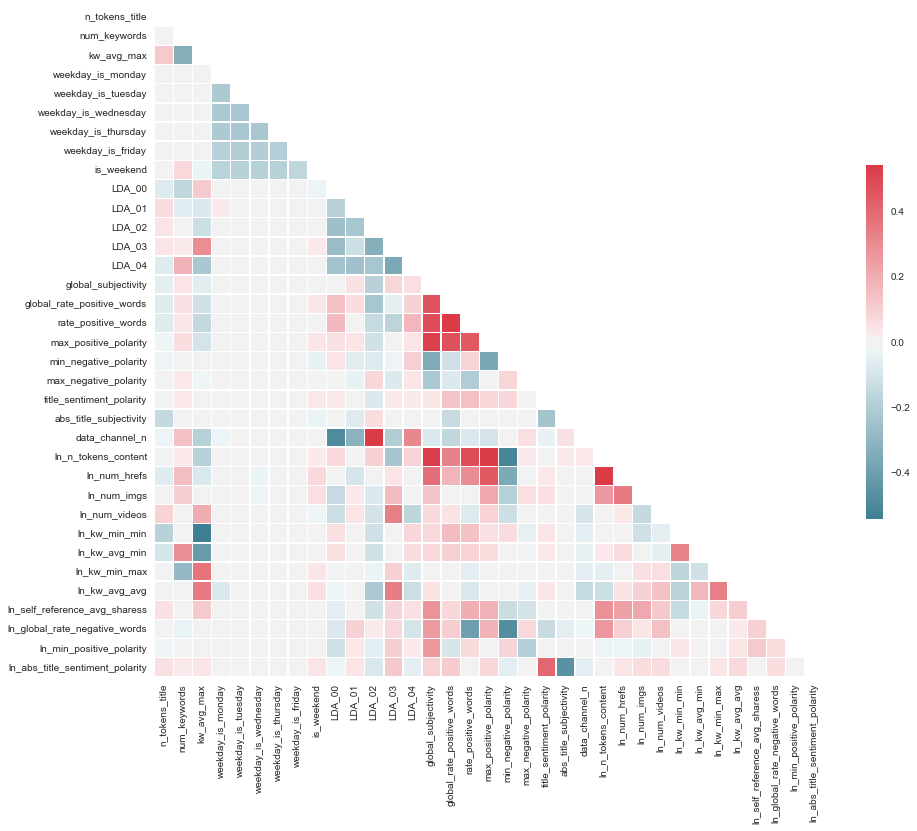

In [50]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

#### Save cleaned / reduced data set to external .csv file  

 - This provides opportunity to just read in this .csv file and no need to repeat data cleaning / reduction process for each execution  
 

In [51]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_lab_02_task_02.csv'

file_2_write = data_dir + data_file

df.to_csv(file_2_write, index = False)


# 	Modeling and Evaluation 2

### Training and test split

In [52]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  copy data frame to classification working data frame
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... data set with text categorical target values 

df_data_channel = df.copy()
del df_data_channel['data_channel_n']

# ... data set with integer categorical target values 

df_data_channel_n = df.copy()
del df_data_channel_n['data_channel']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'data_channel' in df_data_channel:
    y = df_data_channel['data_channel'].values         # set 'data_channel' as dependent
    del df_data_channel['data_channel']                # remove from dataset
    X = df_data_channel.values                         # use everything else for independent EVs

if 'data_channel_n' in df_data_channel_n:
    y_n = df_data_channel_n['data_channel_n'].values    # set 'data_channel' as dependent
    del df_data_channel_n['data_channel_n']             # remove from dataset
    X_n = df_data_channel_n.values                      # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup master train and test , golden traina and test
# ...  master sets - first 80% of original data set which will be base training for model building
# ...  Golden sets - 20% of original will be used in the final best model for prediction
# ...  split into training and test sets
# ....  --> 10 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=




In [53]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up golden test data set
# ... This data-set will be used to evaluate the predictive capability of the final
# ... model on a data set that was not included in any of the prior train/test sets
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(X, y):
    master_X_train = X[train_indices]
    master_y_train = y[train_indices]    
    golden_X_test  = X[test_indices]
    golden_y_test  = y[test_indices]
    print(master_X_train.shape)

for train_indices_n, test_indices_n in cv_object.split(X_n, y_n): 
    master_X_train_n = X_n[train_indices_n]
    master_y_train_n = y_n[train_indices_n]    
    golden_X_test_n  = X_n[test_indices_n]
    golden_y_test_n  = y_n[test_indices_n]
    
    
    

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(31715, 34)


In [54]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up training set to be used on 'best' model from grid search results
# ... This data-set will be used to verify 10-fold-CV-model has results consistent
# ... with the model produced from grid search
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(master_X_train, master_y_train):
    X_train = master_X_train[train_indices]
    y_train = master_y_train[train_indices]    
    X_test  = master_X_train[test_indices]
    y_test  = master_y_train[test_indices]
    print(X_train.shape)

for train_indices_n, test_indices_n in cv_object.split(master_X_train_n, master_y_train_n): 
    X_train_n = master_X_train_n[train_indices_n]
    y_train_n = master_y_train_n[train_indices_n]    
    X_test_n  = master_X_train_n[test_indices_n]
    y_test_n  = master_y_train_n[test_indices_n]


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(25372, 34)


In [55]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = [
    'Model Name',
    'Accuracy',
    'Precision',
    'Recall',
    'FScore',
    'Processing Time'])

i_index=[]
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

# 	Modeling and Evaluation 3	

For task 2 we have chosen the following 4 models:<br>
a. Multinomial logistic regression with parament selection using Grid Search<br>
b. Decision Tree with parament selection using Grid Search<br>
c. Random Forest with parament selection using Grid Search<br>
d. Naive Bayes<br>

Each of these models will be evaluated on Accuracy, Precision, Recall, FScore and Execution time

### a. Multinomial logistic regression
For multinomial LR we have set standard attributes with:
    class_weight = balanced<br>
    multi_class = multinomial<br>
<b>search params:</b><br>
    tolerance parament tol<br>
    Regularization parament C<br>
    
    
#### _Grid selection for logistic regression_

In [56]:
from sklearn.grid_search import GridSearchCV

lr_model = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 10,
    tol = 0.1)

params = {
    'C':[100, 1000], 
    'tol': [0.001, 0.0001]
}

# ... --> changed the scoring on Sat 28-Oct
# ...     - from : log_loss
# ...     - to : neg_log_loss
# ...  (this avoids the deprecation warning)

clf = GridSearchCV(
    lr_model,
    params,
    scoring = 'neg_log_loss',
    refit = 'True',
    n_jobs = -1,
    cv = 5)

grid_search = clf.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#### _Best parameter values for logistic regression_:

In [57]:
best_accuracy
best_parameters

-0.7544798733585832

{'C': 1000, 'tol': 0.001}

#### Create main logistic model using best paraments for further analysis and model comparisons

In [115]:
tic = time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... basic multiclass Logistic Regression
# ... - normalize features based on mean & stdev of each column
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

lr_model1 = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 100,
    tol = 0.001)

lr_model1.fit(X_train, y_train)  # train object

y_hat = lr_model1.predict(X_test) # get test set precitions

toc =  time.clock()

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_hat,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_hat,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_hat,average='weighted'))

exetime = '{0:.4f}'.format(toc-tic)

# print statistics

print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", conf(y_test, y_hat))
print('process time',exetime)
print("\n")

lr_model1_confusion_matrix = conf(y_test, y_hat)

# save statistics for model comparison

raw_data = {
    'Model Name' : 'Logistic Regression',
    'Accuracy' : accuracy,
    'Precision' : precision,
    'Recall' : recall,
    'FScore' : f1_score,
    'Processing Time' : exetime
}

df_tbl = pd.DataFrame(raw_data,
    columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'FScore', 'Processing Time'],
    index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Logistic Regression', lr_model1))

print(lr_model1.coef_)

type(lr_model1.coef_)


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.001, verbose=0,
          warm_start=False)

accuracy 0.7172
precision 0.7451
recall 0.7172
f1_score 0.7279
confusion matrix
 [[ 778   17   44   10  133   37   18]
 [   8  824   26  188   42   11   42]
 [  22    7  160   15   29  101    8]
 [  16  131   20  779   19    2   11]
 [  69   17   45   33  155   11   43]
 [  28   17  263    6   23  775   49]
 [  15   35   38   28   50   67 1078]]
process time 4.0033


[[  7.10746826e-02   9.22976847e-02   1.57618140e+00   8.98852830e-02
    1.60272663e-01   1.00972617e-02   2.11960492e-02  -3.16370518e-02
   -2.98376210e-01   5.20478346e+00  -6.89074244e-01  -1.45573495e+00
   -1.86838790e+00  -1.23980808e+00  -3.18486356e-01  -5.32043559e-03
    2.28193824e-01  -1.05098296e-01   5.34611598e-01   3.04749509e-02
    9.75984043e-04  -3.21656132e-02   2.67978038e-01  -1.85061098e-01
   -3.98674788e-01  -5.32540364e-01   3.95524592e-01   5.26348034e-01
    1.02197578e-02  -1.07521653e+00  -3.34672637e-02  -2.71039291e-02
   -3.23798177e-02  -1.35325900e-01]
 [  1.84397439e-01  -1.05552926e-

numpy.ndarray

In [147]:
channels_list = sorted(df['data_channel'].unique())
channels_list
channels_list.insert(0,0)
channels_list

['Business',
 'Entertainment',
 'Lifestyle',
 'Others',
 'Social Media',
 'Technology',
 'World']

[0,
 'Business',
 'Entertainment',
 'Lifestyle',
 'Others',
 'Social Media',
 'Technology',
 'World']

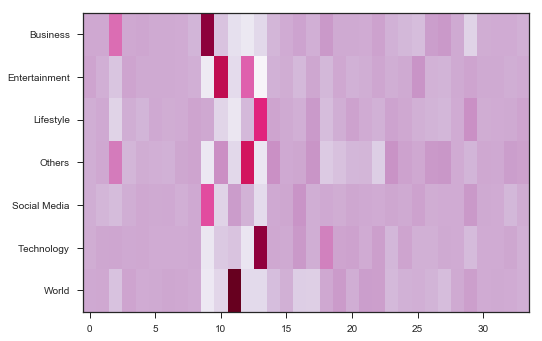

In [149]:
channels_list = sorted(df['data_channel'].unique())
channels_list.insert(0,0)
features_list = df_data_channel.columns.values.tolist()

fig, ax = plt.subplots()

plt.imshow(lr_model1.coef_, cmap = plt.get_cmap('PuRd'), aspect = 'auto')

ax.set_yticklabels(channels_list)
#ax.set_xticklabels(features_list, rotation = 'vertical')

plt.grid(False)

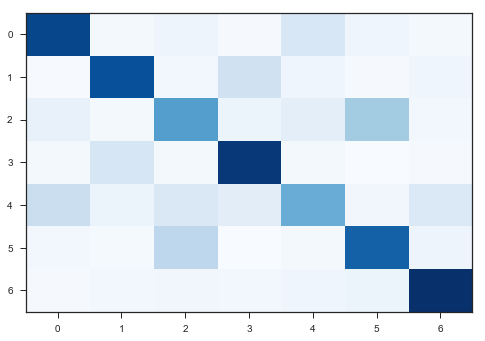

In [108]:
lr_model1_confusion_matrix = conf(y_test, y_hat)

cm_normalized = lr_model1_confusion_matrix.astype('float') / lr_model1_confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, cmap = plt.get_cmap('Blues'), aspect = 'auto')
plt.grid(False)

In [106]:
# Interpret weights

#zip_vars_LR = zip(lr_model1.coef_.T, df_data_channel.columns.values.tolist()) # combine attributes

#print(zip_vars_LR)
#for importance, name in zip_vars_LR:
#    print(name, 'has weight of', importance) # now print them out

n_tokens_title has weight of [ 0.07107468  0.18439744 -0.08411842 -0.0671969  -0.08727657 -0.0581042
  0.04122397]
num_keywords has weight of [ 0.09229768 -0.10555293  0.04765455  0.08541296 -0.30485356  0.1096129
  0.0754284 ]
kw_avg_max has weight of [ 1.5761814  -0.73040719 -1.10383721  1.23258332 -0.49243092  0.1684848
 -0.65057421]
weekday_is_monday has weight of [ 0.08988528  0.18744003 -0.08446851 -0.32123603 -0.08656814  0.04227095
  0.17267642]
weekday_is_tuesday has weight of [ 0.16027266  0.01336719 -0.27428226 -0.05325047  0.07954061  0.07750164
 -0.00314937]
weekday_is_wednesday has weight of [ 0.01009726  0.02476449  0.0515024  -0.1000526   0.00283855 -0.01343948
  0.02428938]
weekday_is_thursday has weight of [ 0.02119605  0.02607091 -0.04950394 -0.18143567  0.06402328 -0.00185168
  0.12150105]
weekday_is_friday has weight of [-0.03163705 -0.00334916 -0.00567335  0.10465671 -0.12489315 -0.00769349
  0.06858949]
is_weekend has weight of [-0.29837621 -0.13231088  0.1735524

### b. Decision Tree Classifier using Grid Search
#### _Grid search parameter set-up_

In [59]:
# Applying Grid Search to find the best model and the best parameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

parameters = [
      {
        'criterion': ['gini'], 
        'max_depth': [None], 
        'min_samples_split': [2, 100, 1000], 
        'min_samples_leaf': [1, 10, 100],
        'max_features': [None], 'max_leaf_nodes': [None]
      },
      {
          'criterion': ['entropy'], 
          'max_depth': [None, 5, 10], 
          'min_samples_split': [2, 100, 1000],
          'min_samples_leaf': [1, 10, 100], 
          'max_leaf_nodes': [None]
      }
     ]

grid_search = GridSearchCV(estimator = DTclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search = grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_min_samples_split = best_parameters['min_samples_split']
best_min_samples_leaf = best_parameters['min_samples_leaf']
best_max_features = best_parameters['max_features']




#### _Best parameters for Decision Tree_

In [60]:
best_accuracy
best_parameters

0.76178464448998895

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

#### _use best parameters to create best Decision Tree model for further analysis and model comparison_

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report

tic = time.clock()

# train and fit

DTclassifier = DecisionTreeClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    min_samples_split = best_min_samples_split,
    min_samples_leaf = best_min_samples_leaf,
    max_features = best_max_features)

DTclassifier.fit(X_train, y_train)
y_predDT = DTclassifier.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predDT))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predDT,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predDT,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predDT,average='weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predDT))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name':'Decision Tree Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Decision Tree Classifier', DTclassifier))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

accuracy 0.7634
precision 0.7478
recall 0.7634
f1_score 0.7515
confusion matrix
 [[ 880   24   10   11   41   42   29]
 [  17  889    3  164   14   21   33]
 [  32   12   80   26   22  160   10]
 [  16  110   13  814    5    6   14]
 [  99   35   22   30  102   27   58]
 [  42   28   53   12    6  950   70]
 [  21   42    2   23   24   72 1127]]
process time 0.7710




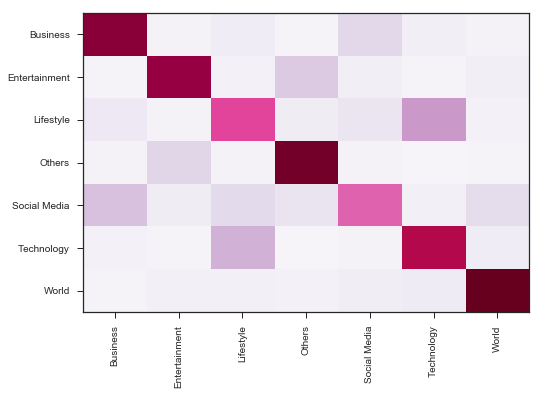

In [151]:
DT_confusion_matrix = confusion_matrix(y_test, y_hat)

cm_normalized = DT_confusion_matrix.astype('float') / DT_confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()

plt.imshow(cm_normalized, cmap = plt.get_cmap('PuRd'), aspect = 'auto')

ax.set_yticklabels(channels_list)
ax.set_xticklabels(channels_list, rotation = "vertical")

plt.grid(False)

In [154]:
DTclassifier.feature_importances_


array([  1.13659340e-05,   2.79413961e-03,   4.51603036e-02,
         1.56701402e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   9.11832176e-04,
         2.13680861e-01,   3.67908165e-02,   2.70898262e-01,
         3.77232890e-02,   2.06726160e-01,   1.83232938e-03,
         1.65309986e-03,   5.33089240e-03,   1.52634516e-03,
         1.17084052e-03,   6.45058089e-05,   2.38070511e-04,
         3.70198199e-04,   1.68237515e-02,   3.53563891e-03,
         9.12717142e-03,   2.27763313e-03,   1.77265645e-02,
         4.32683614e-03,   1.22342248e-02,   1.00809373e-01,
         1.90703292e-03,   1.48896332e-03,   2.69393593e-03,
         1.49892498e-04])

### c. Random Forest Classifier

#### _Grid Search parameter set-up for Random Forest classifier_

In [155]:
RFclf = RandomForestClassifier(
    criterion = 'entropy',
    max_features= 'sqrt',
    max_depth = 5,
    n_estimators = 10,
    n_jobs = -1)

#RFclf.fit(master_X_train, master_y_train)

param_grid =[
    { 
    'criterion': ['gini'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
},
 { 
    'criterion': ['entropy'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
}
]

RF_grid_search = GridSearchCV(
    estimator = RFclf,
    param_grid = param_grid,
    cv = 2)

grid_search = RF_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_features = best_parameters['max_features']
best_n_estimators = best_parameters['n_estimators']


#### _best parameters for Random Forest Classifier_

In [66]:
best_accuracy
best_parameters

0.80230174996058645

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'n_estimators': 500}

#### _using best parameters for main model for further analysis and model comparison_

In [67]:
from sklearn.ensemble import RandomForestClassifier

tic = time.clock()

# train and test 

RFclf = RandomForestClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    max_features = best_max_features,
    n_estimators = best_n_estimators,
    n_jobs = -1)

RFclf.fit(X_train, y_train)
y_predRF = RFclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predRF))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predRF, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predRF, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predRF, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Random Forest Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Random Forest Classifier', RFclf))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

accuracy 0.8061
precision 0.8021
recall 0.8061
f1_score 0.7858
confusion matrix
 [[ 935   14    0   10    8   38   32]
 [  19  939    0  128    3   27   25]
 [  40    9   38   25   12  208   10]
 [  13   48    5  891    0    3   18]
 [  92   32    5   27  126   38   53]
 [  40   19    8    9    8 1030   47]
 [  25   37    1   23    5   66 1154]]
process time 222.4900




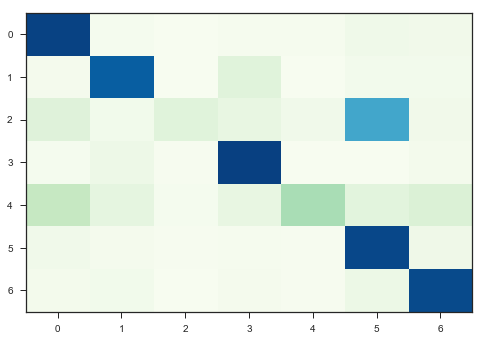

In [124]:
RF_confusion_matrix = confusion_matrix(y_test, y_predRF)

cm_normalized = RF_confusion_matrix.astype('float') / RF_confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, cmap = plt.get_cmap('GnBu'), aspect = 'auto')
plt.grid(False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

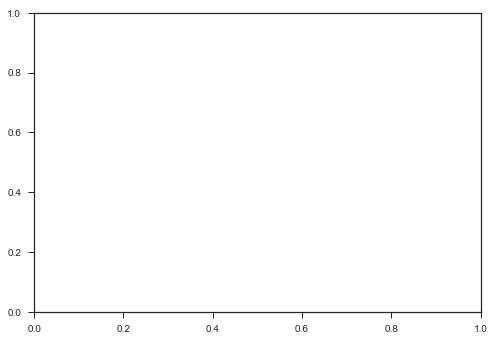

In [156]:
print (RFclf)

y_labels = df_data_channel.columns.values.tolist()

fig, ax = plt.subplots()

plt.barh(range(len(RFclf.feature_importances_)), RFclf.feature_importances_)

ax.set_yticklabels(y_labels, minor = False)

plt.show()




###  d. Naive Bayes  

 - Evaluate both Mulinomial and Gaussian  
 - Gaussian has only default parameters, so will run grid search only on Multinomial  
 


In [70]:
from sklearn.naive_bayes import MultinomialNB

MNBclf = MultinomialNB(
    alpha = 0.01,
    class_prior = None,
    fit_prior = True)

params = {
    'alpha':[0.1, 0.5, 1.0]
}

MNB_grid_search = GridSearchCV(
    MNBclf,
    params,
    cv = 5)

grid_search = MNB_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy
best_parameters

best_alpha = best_parameters['alpha']

0.64105312943402171

{'alpha': 0.1}

In [76]:
tic = time.clock()

# train and test 

MNBclf = MultinomialNB(
    alpha = best_alpha,
    class_prior = None,
    fit_prior = True)

MNBclf.fit(X_train, y_train)
y_predMNB = MNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predMNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predMNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predMNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predMNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predMNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Multinomial Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Multinomial Naïve Bayes', MNBclf))


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

accuracy 0.6372
precision 0.6081
recall 0.6372
f1_score 0.6172
confusion matrix
 [[ 724   32   51   22   33   91   84]
 [  21  674   34  223   10   95   84]
 [  42    9   30   28    2  189   42]
 [  21  205   27  657    9   29   30]
 [ 112   51   21   44   19   53   73]
 [  69   25   27   23    2  868  147]
 [  23   31   25   21   24  117 1070]]
process time 0.3293




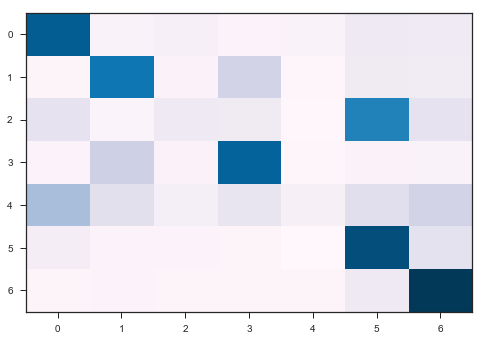

In [125]:
MNB_confusion_matrix = confusion_matrix(y_test, y_predMNB)

cm_normalized = MNB_confusion_matrix.astype('float') / MNB_confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, cmap = plt.get_cmap('PuBu'), aspect = 'auto')
plt.grid(False)


In [77]:
from sklearn.naive_bayes import GaussianNB

tic = time.clock()

# train and test 

GNBclf = GaussianNB()

GNBclf.fit(X_train, y_train)
y_predGNB = GNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predGNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predGNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predGNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predGNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predGNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Gaussian Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Gaussian Naïve Bayes', GNBclf))

GaussianNB(priors=None)

accuracy 0.7195
precision 0.7089
recall 0.7195
f1_score 0.7131
confusion matrix
 [[ 823   19   27    4   76   54   34]
 [  14  865   14  179   25   19   25]
 [  47    3   77   19    7  178   11]
 [   5  200   29  700   35    1    8]
 [ 136   32   28   26   81   25   45]
 [  44   17   90    4   19  930   57]
 [  25   51    6   25   36   80 1088]]
process time 0.1708




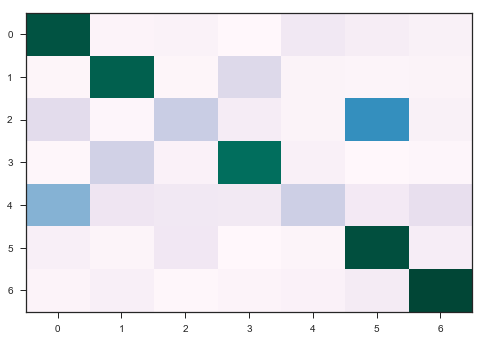

In [126]:
GNB_confusion_matrix = confusion_matrix(y_test, y_predGNB)

cm_normalized = GNB_confusion_matrix.astype('float') / GNB_confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, cmap = plt.get_cmap('PuBuGn'), aspect = 'auto')
plt.grid(False)


#	Modeling and Evaluation 4

In [78]:
# converting acc, pre, recall, fscore and time to numeric values for plots

comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['Precision'] = pd.to_numeric(comparison_tbl['Precision'])
comparison_tbl['Accuracy'] = pd.to_numeric(comparison_tbl['Accuracy'])
comparison_tbl['FScore']= pd.to_numeric(comparison_tbl['FScore'])
comparison_tbl['Processing Time'] = pd.to_numeric(comparison_tbl['Processing Time'])
comparison_tbl['Recall'] = pd.to_numeric(comparison_tbl['Recall'])
comparison_tbl


,Model Name,Accuracy,Precision,Recall,FScore,Processing Time
0,Logistic Regression,0.7172,0.7451,0.7172,0.7279,4.1552
1,Decision Tree Classifier,0.7634,0.7478,0.7634,0.7515,0.7710
2,Random Forest Classifier,0.8061,0.8021,0.8061,0.7858,222.4900
3,Multinomial Naïve Bayes,0.6372,0.6081,0.6372,0.6172,0.3293
4,Gaussian Naïve Bayes,0.7195,0.7089,0.7195,0.7131,0.1708


In [88]:
comparison_tbl['Model Name']

0         Logistic Regression
1    Decision Tree Classifier
2    Random Forest Classifier
3     Multinomial Naïve Bayes
4        Gaussian Naïve Bayes
Name: Model Name, dtype: object

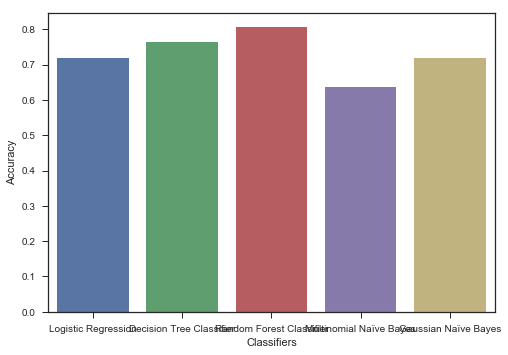

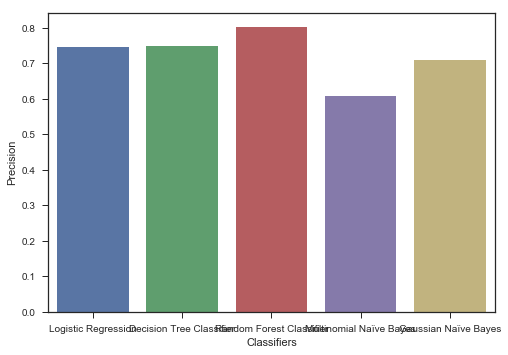

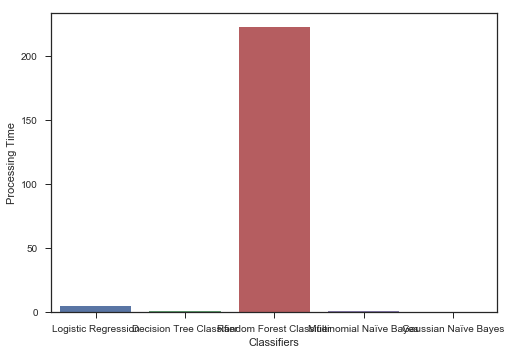

In [96]:
from pylab import rcParams
%matplotlib inline

#comparison_tbl.plot()

rcParams['figure.figsize'] = 8, 5
sns.set(style = "ticks")

sns.barplot(data = comparison_tbl, y = 'Accuracy', x = 'Model Name')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

sns.barplot(data = comparison_tbl, y = 'Precision', x = 'Model Name')

plt.xlabel('Classifiers')
plt.ylabel('Precision')
plt.show()

sns.barplot(data = comparison_tbl, y = 'Processing Time', x = 'Model Name')
plt.xlabel('Classifiers')
plt.ylabel('Processing Time')
plt.show()


# 10-K Cross-Validation for each classifier
For each classifier we run 10 fold cross validation which will help us narrow down one final model

In [2]:
from sklearn import model_selection

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = model_selection.cross_val_score(
        model,
        master_X_train,
        master_y_train,
        cv = 10,
        scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "\n\t%50s: %.3f (%.4f)\n\n" % (name, cv_results.mean(), cv_results.std())
    print(cv_results)
    print(msg)

NameError: name 'models' is not defined

{'boxes': [<matplotlib.lines.Line2D at 0x7f39203fb0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f39203dc7b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f39203f2e48>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f39203aa630>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f39203fbb70>,
  <matplotlib.lines.Line2D at 0x7f39203a39b0>]}

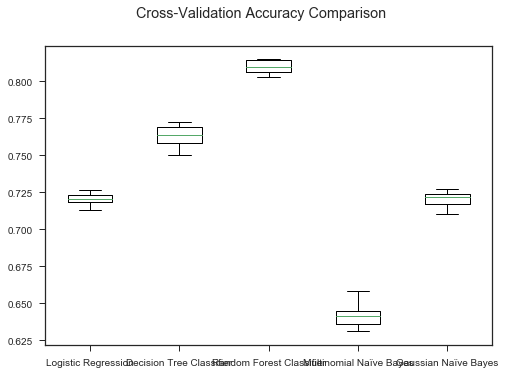

In [82]:
# boxplot accuracy comparison

fig = plt.figure()
fig.suptitle('Cross-Validation Accuracy Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names)
plt.show()


#### Golden test data set prediction with our final model

our final best model is Random Forest Classifier. We will run prediction on that fit with the test data set we set aside at the beggining of the project. We will calculate statistics for the prediction.

In [83]:
y_predFinal = RFclf.predict(golden_X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(golden_y_test, y_predFinal))
precision = '{0:.4f}'.format(metrics.precision_score(golden_y_test, y_predFinal, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(golden_y_test, y_predFinal, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(golden_y_test, y_predFinal, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy", accuracy )
print("precision", precision )
print("recall", recall )
print("f1_score", f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time', exetime)
print("\n")


accuracy 0.8140
precision 0.8119
recall 0.8140
f1_score 0.7954
confusion matrix
 [[ 935   14    0   10    8   38   32]
 [  19  939    0  128    3   27   25]
 [  40    9   38   25   12  208   10]
 [  13   48    5  891    0    3   18]
 [  92   32    5   27  126   38   53]
 [  40   19    8    9    8 1030   47]
 [  25   37    1   23    5   66 1154]]
process time 2590.4913




### __Final Statement regarding Task 2 Classifiers

# 	Exceptional Work	
We have implemented Grid search in our parament selection process.